# Diabetic Retinapathy Classification

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Setting all the Constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE= 32
CHANNELS= 3
EPOCHS=50

# Import data into tensorflow dataset object

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle= True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
   print (image_batch. shape)
   print(label_batch.numpy())


(32, 256, 256, 3)
[0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 2 1 1 0]


# Visualization of some Images


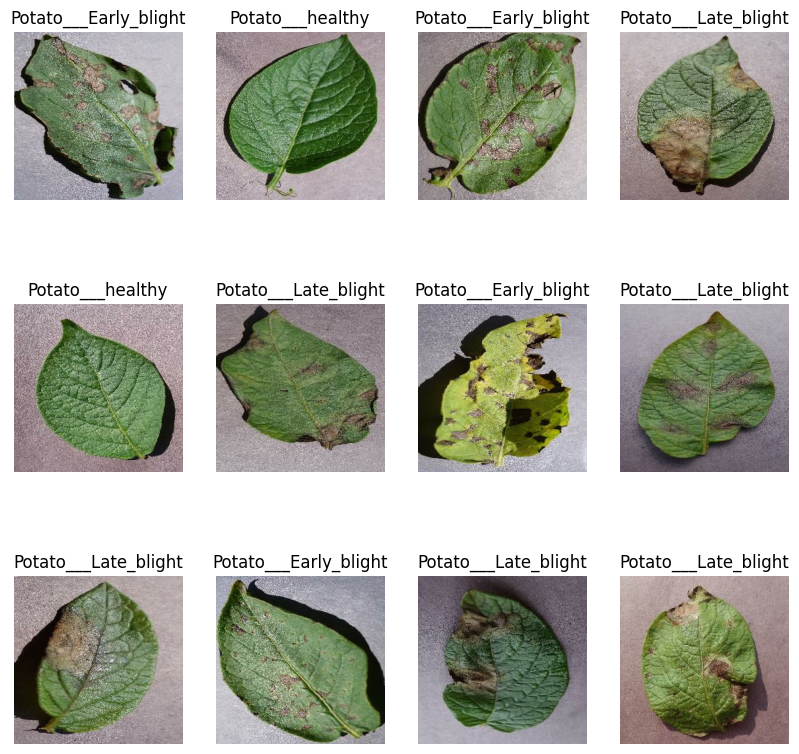

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

# Train-Test Split

80% ==> training
20% ==> 10% validation, 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
         ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

# Prefetch the Dataset

In [17]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building

In [18]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
layers.experimental . preprocessing .Rescaling(1.0/255)
])


# Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data

In [19]:
data_augmentation = tf.keras.Sequential([
layers. experimental . preprocessing. RandomFlip("horizontal_and_vertical"),
layers.experimental . preprocessing .RandomRotation(0.2),
])


In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Model Architecture
Using convolutional neural network (CNN) here. CNN is popular for image classification tasks. 

HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/zfiSAzpy9NM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 170s 2s/step - loss: 0.8984 - accuracy: 0.4948 - val_loss: 0.8476 - val_accuracy: 0.5208
Epoch 2/10
54/54 [==============================] - 87s 2s/step - loss: 0.7066 - accuracy: 0.6453 - val_loss: 0.4959 - val_accuracy: 0.7760
Epoch 3/10
54/54 [==============================] - 89s 2s/step - loss: 0.5054 - accuracy: 0.7784 - val_loss: 0.4068 - val_accuracy: 0.8073
Epoch 4/10
54/54 [==============================] - 91s 2s/step - loss: 0.3821 - accuracy: 0.8443 - val_loss: 0.3170 - val_accuracy: 0.8594
Epoch 5/10
54/54 [==============================] - 96s 2s/step - loss: 0.3676 - accuracy: 0.8519 - val_loss: 0.3052 - val_accuracy: 0.9167
Epoch 6/10
54/54 [==============================] - 88s 2s/step - loss: 0.2312 - accuracy: 0.9057 - val_loss: 0.1588 - val_accuracy: 0.9427
Epoch 7/10
54/54 [==============================] - 93s 2s/step - loss: 0.1531 - accuracy: 0.9444 - val_loss: 0.3647 - val_accuracy: 0.8646
Epoch 8/10
54/54 [=

In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 22s 375ms/step - loss: 0.2053 - accuracy: 0.9141


In [26]:
scores

[0.20528389513492584, 0.9140625]

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history.history['loss'][:5]

[0.8983888030052185,
 0.7065571546554565,
 0.505439817905426,
 0.3820541799068451,
 0.367649108171463]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [30]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8983888030052185,
 0.7065571546554565,
 0.505439817905426,
 0.3820541799068451,
 0.367649108171463]

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 815ms/step
predicted label: Potato___Early_blight


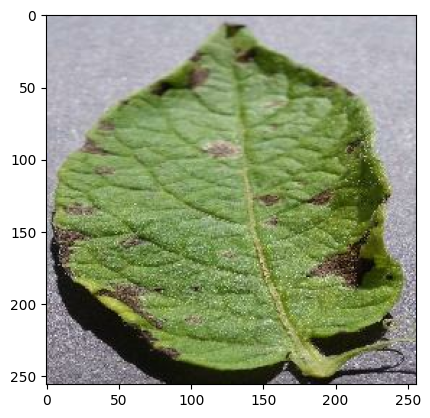

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

ValueError: x and y must have same first dimension, but have shapes (50,) and (10,)

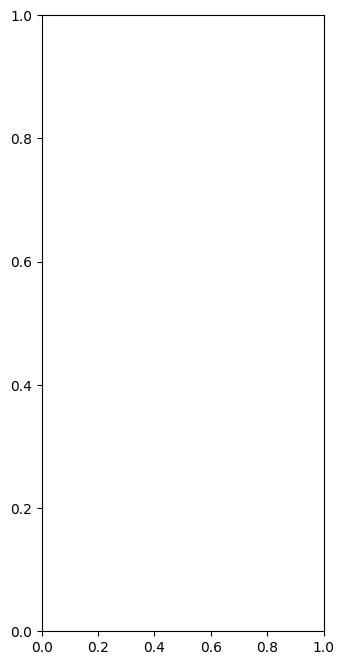

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()